This file builds ML datasets with different lags. <br>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prep-training-data" data-toc-modified-id="Prep-training-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prep training data</a></span></li><li><span><a href="#Plot-correlation-to-check-for-redundant-features" data-toc-modified-id="Plot-correlation-to-check-for-redundant-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot correlation to check for redundant features</a></span></li><li><span><a href="#Prepare-dataset" data-toc-modified-id="Prepare-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare dataset</a></span></li><li><span><a href="#Inspect-results" data-toc-modified-id="Inspect-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Inspect results</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import numpy as np
import seaborn as sns
from matplotlib.colors import LogNorm
import math

import jetson_configs as cfg
from src.ml_helpers.make_ml_dataset import *

In [2]:
current_month = cfg.current_month
admin_level='admin1'

## Prep training data

Format for the data is:

    [ target ]  [3, 12 month own admin lag] [region dummy] [month dummy] [3, 12 month other admin lag] [linear time var] [missing vals]

In [3]:
df = pd.read_csv(f"data/compiled/master_{admin_level}.csv", parse_dates=['date'], index_col=['date', 'region'])

len(df.index.unique().tolist())

2160

## Plot correlation to check for redundant features

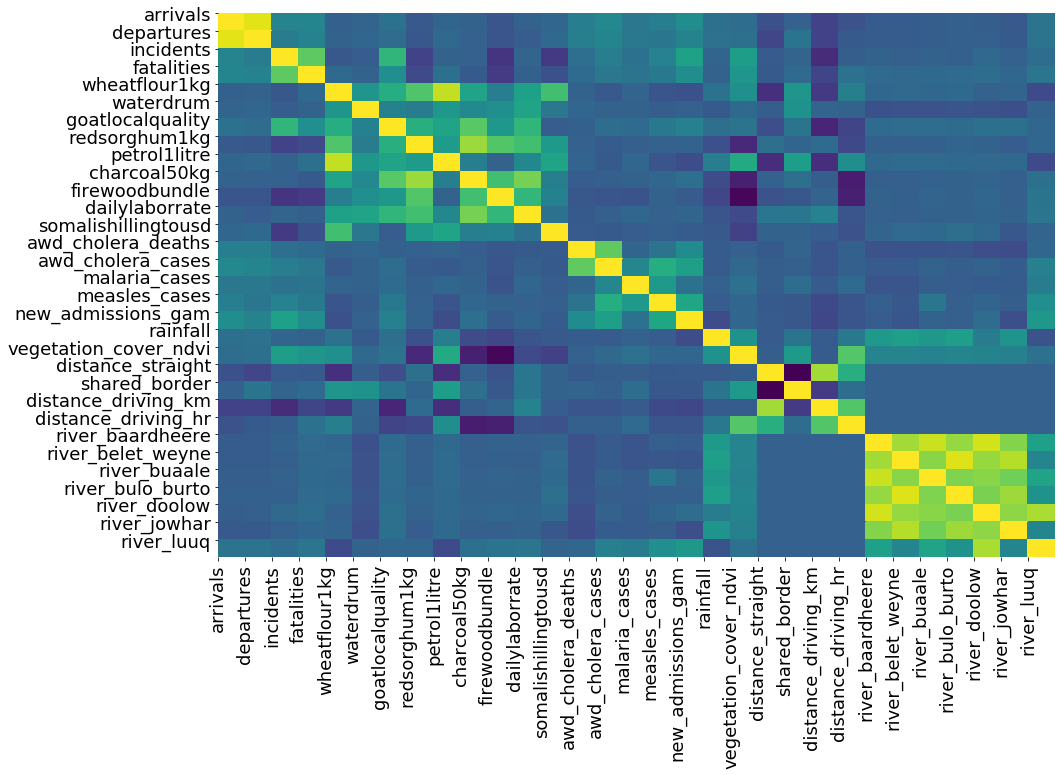

In [4]:
fig,ax = plt.subplots(1,1, figsize=[15,10])

#ax.imshow(df.corr())
sns.heatmap(df.corr(), ax=ax, cbar=None, cmap='viridis')
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns, fontsize=18)
ax.set_yticklabels(df.columns, fontsize=18)


plt.savefig("figures/corrplot.png", dpi=100, bbox_inches="tight")

## Prepare dataset

In [5]:
learn_df = make_ml_features(current_month, admin_level)

Dropped entirely missing columns:  []
Dropped duplicate columns:  ['miss_vegetation_cover_ndvi']


## Inspect results

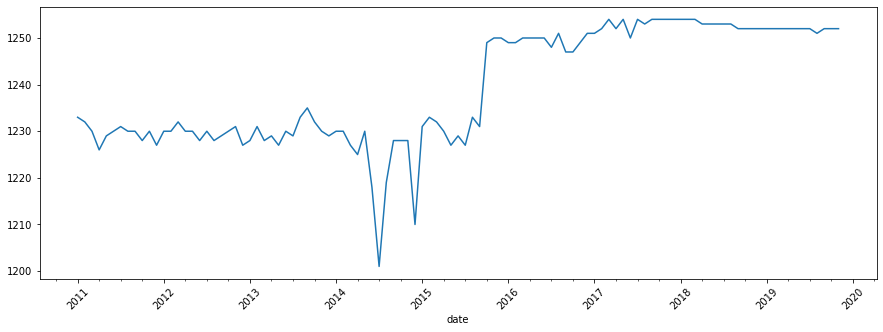

In [6]:
# Check one dataframe for missing values
learn_df = pd.read_csv(f'ml/input_data/learn_df_admin1.csv', index_col=['region', 'date'], parse_dates=['date'])
learn_df.unstack(level='date').count().unstack(level=1).sum().plot(figsize=[15,5], rot=45)

In [7]:
# Check for data leakage
for c in learn_df.columns:
    if "arrivals" not in c:
        assert( (learn_df.arrivals.isna() | (learn_df[c]==learn_df['arrivals'])).all() == False)

In [8]:
# Identify months with most missing observations
learn_df.unstack(level='date').count().unstack(level=1).sum().sort_values().head()

date
2014-07-01    1201
2014-12-01    1210
2014-06-01    1218
2014-08-01    1219
2014-04-01    1225
dtype: int64

In [9]:
# Identify variables with most missing observations
learn_df.count().sort_values().head()

river_doolow            900
somalishillingtousd    1599
arrivals               1668
departures             1745
redsorghum1kg          1767
dtype: int64

In [10]:
# Check total number of dates in the dataset
len(learn_df.index.get_level_values('date').unique())

107